# Kinfe Edge Scan Notebook

In [ ]:
# Import python libs and utils.py
import numpy as np 
import h5py
import matplotlib.pyplot as plt
import scipy.io
from scipy.signal import savgol_filter, medfilt
from scipy.optimize import curve_fit
from scipy import special
import os
import re
from utils import *

### Load the data in

In [ ]:
###############################################
runNumbers = []  # enter the run numbers to be loaded
folder = '/sdf/data/lcls/ds/cxi/EXPERIMENT/hdf5/smalldata/' # insert here the directory path where .h5 files are stored
scanType = 'x' # x or y
###############################################
# (1) keys_to_combine: some keys loaded for each shot & stored per shot 
# (2) keys_to_sum: some keys loaded per each run and added 
# (3) keys_to_check : check if some keys exits and have same values in all runs and load these keys 
keys_to_combine = ['ipm_dg2/sum',
                   # 'ipm_dg3/sum',
                   # 'ipm_hfx_dg2/sum',
                   'scan/pinhole_x',
                   'scan/pinhole_y',
                   # 'alvium_u1/laser_com',
                   # 'alvium_u1/laser_sum',
                   # 'Acqiris/FastTiming_area',
                   # 'Acqiris/Laser_area',
                   'qadc0/full_area',
                   'qadc1/full_area',
                   'lightStatus/laser',
                   'lightStatus/xray']
keys_to_sum = [] # None here
keys_to_check = [] # None here
# Load the data in
data = combineRuns(runNumbers, folder, keys_to_combine, keys_to_sum, keys_to_check, verbose=False)  # this is the function to load the data with defined keys
# Bounds for the analysis.
qadc0_low = 4650
qadc0_high = 6200
qadc1_low = 5050
qadc1_high = 5400

qadc0_full_area = data['qadc0/full_area']  # diode signal for laser upsteam
qadc1_full_area = data['qadc1/full_area'] # diode signal for laser after IP
# Cropping the data
qadc0_cropped = qadc0_full_area[:, qadc0_low:qadc0_high]
qadc1_cropped = qadc1_full_area[:, qadc1_low:qadc1_high]
# Calculate the sums for each event
qadc0_sum_per_event = qadc0_cropped.sum(axis=1)
qadc1_sum_per_event = qadc1_cropped.sum(axis=1)
# Calculate the ratio QADC1 / QADC0 for each event
qadc_ratio = qadc1_sum_per_event / qadc0_sum_per_event

# Picking data from the scan type
if scanType == 'x':
    pinhole = data['scan/pinhole_x']
    else:
    pinhole = data['scan/pinhole_y']

# Aggregate data by unique `pinhole` values
unique_pinhole = np.unique(pinhole)
mean_qadc_ratio = []
std_qadc_ratio = []

# Here we loop through all the positions and create the final data
for value in unique_pinhole:
    mask = pinhole == value
    qadc_ratio_values = qadc_ratio[mask]
    mean_qadc_ratio.append(np.mean(qadc_ratio_values))
    std_qadc_ratio.append(np.std(qadc_ratio_values))

mean_qadc_ratio = np.array(mean_qadc_ratio)
std_qadc_ratio = np.array(std_qadc_ratio)

laserOn = data['lightStatus/laser'].astype(bool)  # laser on events
xrayOn = data['lightStatus/xray'].astype(bool)  # xray on events

run_indicator = data['run_indicator'] # run indicator for each shot

#UV_com = data['alvium_u1/laser_com']  # center of mass for laser (pump) pointing
#UV_sum = data['alvium_u1/laser_sum']   # intensity sum for laser (pump) pointing

dg2 = data['ipm_dg2/sum']   # upstream diode x-ray intensity
#dg3 = data['ipm_dg3/sum']    # downstream diode x-ray intensity

# Fit the data with error function to get Full width at half maximum (FWHM)

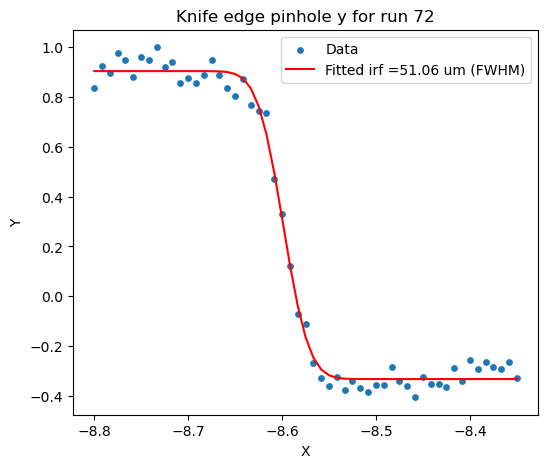

Fitted Parameters:
width = 0.05105545752030906


In [46]:
# fit the data! -- Baxter
def custom_erf(x, a, sigma, mu, b):
    return a*(special.erf((x - mu) / (np.sqrt(2) * sigma))) + b
# Getting the final data which we will fit the error function to
x_data = unique_pinhole
y_data = mean_qadc_ratio / np.max(mean_qadc_ratio) # Percent calculation

# Fit the function to the data
popt, pcov = curve_fit(custom_erf,x_data, y_data,p0=(1, 0.1,np.median(unique_pinhole),-0.1))

# Generate fitted data to compare
y_fit = custom_erf(x_data, *popt)

# Plot the original data and the fitted curve
plt.figure(figsize=(6, 5))
plt.scatter(x_data, y_data, label='Data', s=15)
plt.plot(x_data, y_fit, label=f'Fitted irf ={popt[1]*2.355*1000:.2f} um (FWHM)', color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Knife edge pinhole {scanType} for run {runNumbers[0]}')
plt.legend()
# plt.grid()
plt.show()

# Print the fitted parameters
print("Fitted Parameters:")
# print(f"x0: {x0_fit:.3f}, w: {w_fit:.3f}, a: {a_fit:.3f}, b: {b_fit:.3f}, min: {min_fit:.3f}, max: {max_fit:.3f}, c: {c_fit:.3f}")
print(f'width = {popt[1] * 2.355}')
